This notebook follows the tutorial SEACell_computation.ipynb found in the github repo dpeerlab/SEACElls

Link to original notebook:
https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import SEACells

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

This notebook requires one data file

Link to new_atac.h5ad:
https://drive.google.com/file/d/17yv7E57gpELHyIMFD2bRvIx_ettP1BV1/view?usp=share_link

In [9]:
atac_ad = sc.read('new_atac.h5ad')

In [10]:
atac_ad

AnnData object with n_obs × n_vars = 11926 × 242409
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'SEACell', 'celltype'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'GeneScores', 'X_svd', 'X_umap'
    obsp: 'connectivities', 'distances'

In [11]:
## User defined parameters

## Core parameters 
n_SEACells = 170
build_kernel_on = 'X_svd' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [12]:
model = SEACells.core.SEACells(atac_ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [13]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...


2023-05-03 13:48:59.366251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computing radius for adaptive bandwidth kernel...


  0%|          | 0/11926 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/11926 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/11926 [00:00<?, ?it/s]

Constructing CSR matrix...


/Users/shelbywengreen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


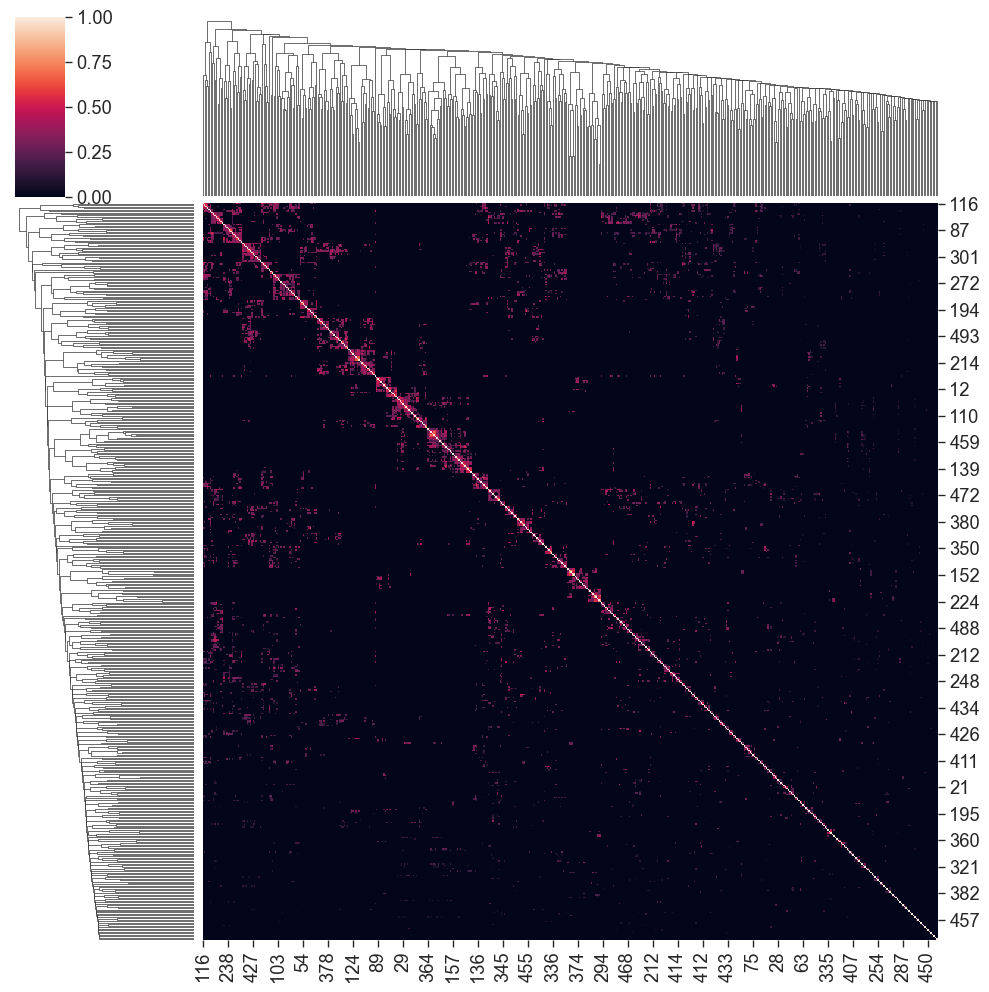

In [14]:
sns.clustermap(M.toarray()[:500,:500])

In [15]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...


/Users/shelbywengreen/opt/anaconda3/lib/python3.9/site-packages/palantir/utils.py:57: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Done.
Sampling waypoints ...
Done.
Selecting 156 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 60.84it/s]

Selecting 14 cells from greedy initialization.


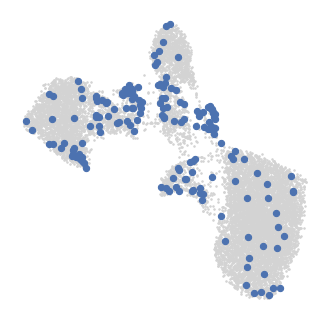

In [16]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(atac_ad, model)

In [17]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00190
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 34 iterations.


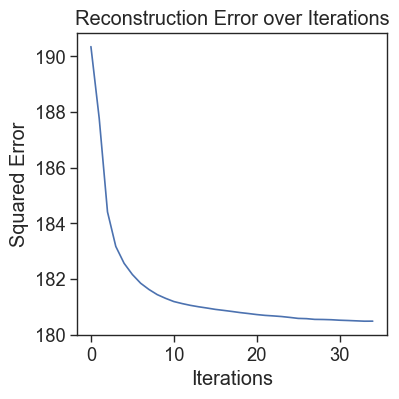

In [18]:
# Check for convergence 
model.plot_convergence()

In [19]:
atac_ad.obs[['SEACell']].head()

,SEACell
index,
CAGAACCGTTCACTGT-1,SEACell-20
ATTCATGAGATGCCTG-1,SEACell-27
TTGACATCAGCGCTTG-1,SEACell-105
CCTTGCGTCCTTCGTA-1,SEACell-70
CCTGCTCCAGCAAGTG-1,SEACell-17


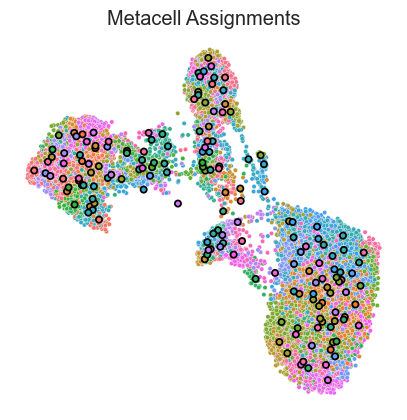

In [20]:
SEACells.plot.plot_2D(atac_ad, key='X_umap', colour_metacells=True)

/Users/shelbywengreen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


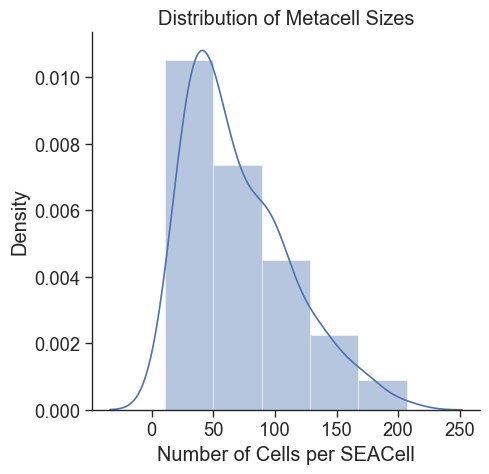

,size
SEACell,
SEACell-0,100
SEACell-1,26
SEACell-10,107
SEACell-100,50
SEACell-101,66
...,...
SEACell-95,71
SEACell-96,15
SEACell-97,23


In [21]:
SEACells.plot.plot_SEACell_sizes(atac_ad, bins=5)

In [22]:
atac_ad.write("atac_metacells.h5ad")